In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import plotly.figure_factory as ff
import tensorflow as tf
from tensorflow.python.keras.layers import Dense, Dropout, LSTM
from tensorflow.python.keras import Sequential
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import OrdinalEncoder
from pandas import DataFrame
from pandas import concat
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, precision_score, recall_score, f1_score
import seaborn as sns

In [2]:
months = ['October', 'November', 'December', 'January', 'February', 'March', 'April']

In [3]:
acc = list()

In [4]:
f1 = list()

In [5]:
err = list()

In [6]:
house_data = pd.read_csv("../preprocessed_data/std_test_data_6150c70f76a3f4b0c6e303de7da9422aceb37345.csv")

In [7]:
house_data.head()

,index,hour_sin,hour_cos,month_sin,month_cos,day_sin,day_cos,Month,DayOfWeek,HourofDay,Day,T_ctrl,T_stp_heat,Humidity,auxHeat1,fan,Thermostat_Temperature,T_out,RH_out
0,0,0.0,1.0,0.0,1.0,0.755303,0.484974,1,1,0,1,1.177675,1.14455,-0.270977,0,0,1.177675,0.322013,1.760593
1,1,0.0,1.0,0.0,1.0,0.755303,0.484974,1,1,0,1,1.177675,1.14455,-0.270977,0,17,1.177675,0.322013,1.760593
2,2,0.0,1.0,0.0,1.0,0.755303,0.484974,1,1,0,1,1.177675,1.14455,-0.270977,6,19,1.177675,0.322013,1.760593
3,3,0.0,1.0,0.0,1.0,0.755303,0.484974,1,1,0,1,0.398793,1.14455,-0.270977,20,20,0.398793,0.322013,1.760593
4,4,0.0,1.0,0.0,1.0,0.755303,0.484974,1,1,0,1,0.398793,1.14455,-0.270977,20,20,0.398793,0.322013,1.760593


In [8]:
house_data.Month.value_counts()

12    8918
11    8621
1     8612
3     8255
4     8244
10    7311
2     5221
5     4975
6     1305
Name: Month, dtype: int64

In [9]:
def series_to_supervised(data, n_in = 1, n_out = 1, dropnan = True):
    
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# October

In [10]:
working_df = house_data[house_data.Month == 10]

working_df = working_df[['T_ctrl', 'T_stp_heat', 'auxHeat1', 'T_out', 'RH_out']]
cols = ['T_ctrl', 'T_stp_heat', 'T_out', 'RH_out', 'auxHeat1']
working_df = working_df[cols]

reframed = series_to_supervised(working_df, 6, 1)

y_auxHeat = reframed['var5(t)']
y_auxHeat = to_categorical(y_auxHeat)
X = reframed.drop(labels = ["var5(t)"], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y_auxHeat, test_size = 0.2, shuffle = True)

X_train = X_train.values
X_test = X_test.values

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(5844, 34) (5844, 21) (1461, 34) (1461, 21)


In [11]:
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu', input_dim = 34))

# Adding the second hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the output layer
classifier.add(Dense(units = 21, kernel_initializer = 'uniform', activation = 'softmax'))

# Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy']) 

# Fitting the ANN to the Training set
history = classifier.fit(X_train, y_train, validation_data = (X_test, y_test), batch_size = 10, epochs = 20, shuffle = True)

Train on 5844 samples, validate on 1461 samples
Epoch 1/20
5844/5844 [==============================] - 3s 460us/sample - loss: 0.4460 - accuracy: 0.9577 - val_loss: 0.1927 - val_accuracy: 0.9685
Epoch 2/20
5844/5844 [==============================] - 2s 366us/sample - loss: 0.1650 - accuracy: 0.9738 - val_loss: 0.1854 - val_accuracy: 0.9713
Epoch 3/20
5844/5844 [==============================] - 2s 369us/sample - loss: 0.1555 - accuracy: 0.9752 - val_loss: 0.1798 - val_accuracy: 0.9740
Epoch 4/20
5844/5844 [==============================] - 2s 368us/sample - loss: 0.1503 - accuracy: 0.9766 - val_loss: 0.1850 - val_accuracy: 0.9733
Epoch 5/20
5844/5844 [==============================] - 2s 364us/sample - loss: 0.1451 - accuracy: 0.9771 - val_loss: 0.1754 - val_accuracy: 0.9726
Epoch 6/20
5844/5844 [==============================] - 2s 404us/sample - loss: 0.1454 - accuracy: 0.9778 - val_loss: 0.1691 - val_accuracy: 0.9740
Epoch 7/20
5844/5844 [==============================] - 2s 411us

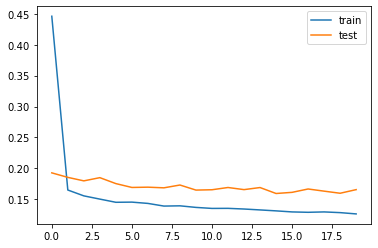

In [12]:
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'test')
plt.legend()
plt.show()

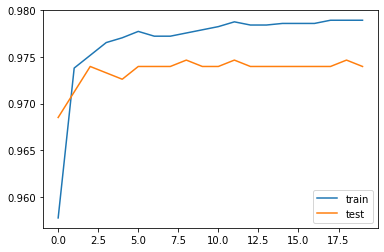

In [13]:
plt.plot(history.history['accuracy'], label = 'train')
plt.plot(history.history['val_accuracy'], label = 'test')
plt.legend()
plt.show()

In [14]:
y_predicted = classifier.predict(X_test)

y_predicted = np.argmax(y_predicted, axis = 1)

y_test = np.argmax(y_test, axis = 1)

test_sum = 0
for i in range(len(y_test)):
    test_sum += (y_test[i] * 15)

print(test_sum)

predicted_sum = 0
for i in range(len(y_predicted)):
    predicted_sum += (y_predicted[i] * 15)

print(predicted_sum)

print("Error Percentage in predicted values is : {} %".format(np.absolute((predicted_sum - test_sum)/test_sum)*100))
err.append(np.absolute((predicted_sum - test_sum)/test_sum)*100)

21795
22500
Error Percentage in predicted values is : 3.2346868547832073 %


In [15]:
f1_score(y_test, y_predicted, average = 'weighted')

0.964766674272015

In [16]:
f1.append(f1_score(y_test, y_predicted, average = 'weighted'))

In [17]:
acc.append(max(history.history['accuracy']))

# November

In [18]:
working_df = house_data[house_data.Month == 11]

working_df = working_df[['T_ctrl', 'T_stp_heat', 'auxHeat1', 'T_out', 'RH_out']]
cols = ['T_ctrl', 'T_stp_heat', 'T_out', 'RH_out', 'auxHeat1']
working_df = working_df[cols]

reframed = series_to_supervised(working_df, 6, 1)

y_auxHeat = reframed['var5(t)']
y_auxHeat = to_categorical(y_auxHeat)
X = reframed.drop(labels = ["var5(t)"], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y_auxHeat, test_size = 0.2, shuffle = True)

X_train = X_train.values
X_test = X_test.values

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(6892, 34) (6892, 21) (1723, 34) (1723, 21)


In [19]:
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu', input_dim = 34))

# Adding the second hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the output layer
classifier.add(Dense(units = 21, kernel_initializer = 'uniform', activation = 'softmax'))

# Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy']) 

# Fitting the ANN to the Training set
history = classifier.fit(X_train, y_train, validation_data = (X_test, y_test), batch_size = 10, epochs = 20, shuffle = True)

Train on 6892 samples, validate on 1723 samples
Epoch 1/20
6892/6892 [==============================] - 3s 433us/sample - loss: 0.7881 - accuracy: 0.8745 - val_loss: 0.3949 - val_accuracy: 0.9338
Epoch 2/20
6892/6892 [==============================] - 3s 393us/sample - loss: 0.4564 - accuracy: 0.9161 - val_loss: 0.3815 - val_accuracy: 0.9367
Epoch 3/20
6892/6892 [==============================] - 3s 379us/sample - loss: 0.4349 - accuracy: 0.9211 - val_loss: 0.3778 - val_accuracy: 0.9362
Epoch 4/20
6892/6892 [==============================] - 3s 374us/sample - loss: 0.4240 - accuracy: 0.9234 - val_loss: 0.3666 - val_accuracy: 0.9385
Epoch 5/20
6892/6892 [==============================] - 3s 425us/sample - loss: 0.4156 - accuracy: 0.9241 - val_loss: 0.3591 - val_accuracy: 0.9385
Epoch 6/20
6892/6892 [==============================] - 3s 457us/sample - loss: 0.4088 - accuracy: 0.9251 - val_loss: 0.3521 - val_accuracy: 0.9379
Epoch 7/20
6892/6892 [==============================] - 5s 699us

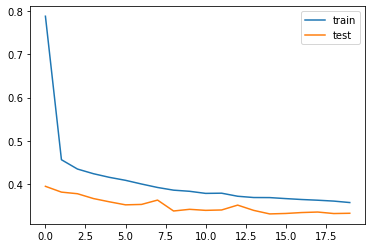

In [20]:
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'test')
plt.legend()
plt.show()

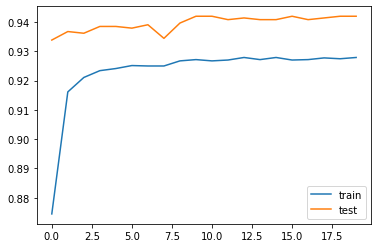

In [21]:
plt.plot(history.history['accuracy'], label = 'train')
plt.plot(history.history['val_accuracy'], label = 'test')
plt.legend()
plt.show()

In [22]:
y_predicted = classifier.predict(X_test)

y_predicted = np.argmax(y_predicted, axis = 1)

y_test = np.argmax(y_test, axis = 1)

test_sum = 0
for i in range(len(y_test)):
    test_sum += (y_test[i] * 15)

print(test_sum)

predicted_sum = 0
for i in range(len(y_predicted)):
    predicted_sum += (y_predicted[i] * 15)

print(predicted_sum)

print("Error Percentage in predicted values is : {} %".format(np.absolute((predicted_sum - test_sum)/test_sum)*100))
err.append(np.absolute((predicted_sum - test_sum)/test_sum)*100)

92415
93600
Error Percentage in predicted values is : 1.2822593734783314 %


In [23]:
f1_score(y_test, y_predicted, average = 'weighted')

0.9174807791384109

In [24]:
f1.append(f1_score(y_test, y_predicted, average = 'weighted'))

In [25]:
acc.append(max(history.history['accuracy']))

# December

In [26]:
working_df = house_data[house_data.Month == 12]

working_df = working_df[['T_ctrl', 'T_stp_heat', 'auxHeat1', 'T_out', 'RH_out']]
cols = ['T_ctrl', 'T_stp_heat', 'T_out', 'RH_out', 'auxHeat1']
working_df = working_df[cols]

reframed = series_to_supervised(working_df, 6, 1)

y_auxHeat = reframed['var5(t)']
y_auxHeat = to_categorical(y_auxHeat)
X = reframed.drop(labels = ["var5(t)"], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y_auxHeat, test_size = 0.2, shuffle = True)

X_train = X_train.values
X_test = X_test.values

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(7129, 34) (7129, 21) (1783, 34) (1783, 21)


In [27]:
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu', input_dim = 34))

# Adding the second hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the output layer
classifier.add(Dense(units = 21, kernel_initializer = 'uniform', activation = 'softmax'))

# Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy']) 

# Fitting the ANN to the Training set
history = classifier.fit(X_train, y_train, validation_data = (X_test, y_test), batch_size = 10, epochs = 20, shuffle = True)

Train on 7129 samples, validate on 1783 samples
Epoch 1/20
7129/7129 [==============================] - 3s 482us/sample - loss: 0.8008 - accuracy: 0.8645 - val_loss: 0.5310 - val_accuracy: 0.9091
Epoch 2/20
7129/7129 [==============================] - 3s 380us/sample - loss: 0.4607 - accuracy: 0.9186 - val_loss: 0.4953 - val_accuracy: 0.9153
Epoch 3/20
7129/7129 [==============================] - 3s 375us/sample - loss: 0.4421 - accuracy: 0.9213 - val_loss: 0.4795 - val_accuracy: 0.9170
Epoch 4/20
7129/7129 [==============================] - 3s 389us/sample - loss: 0.4313 - accuracy: 0.9236 - val_loss: 0.4819 - val_accuracy: 0.9192
Epoch 5/20
7129/7129 [==============================] - 3s 484us/sample - loss: 0.4256 - accuracy: 0.9231 - val_loss: 0.4913 - val_accuracy: 0.9181
Epoch 6/20
7129/7129 [==============================] - 4s 515us/sample - loss: 0.4186 - accuracy: 0.9245 - val_loss: 0.4635 - val_accuracy: 0.9192
Epoch 7/20
7129/7129 [==============================] - 3s 389us

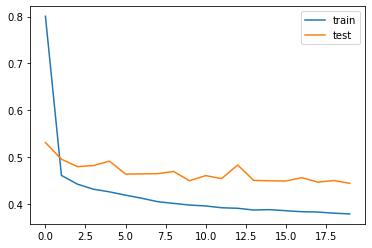

In [28]:
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'test')
plt.legend()
plt.show()

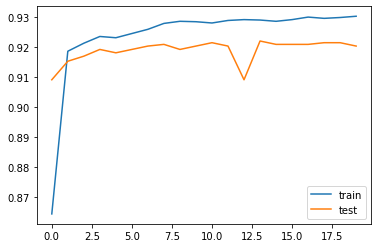

In [29]:
plt.plot(history.history['accuracy'], label = 'train')
plt.plot(history.history['val_accuracy'], label = 'test')
plt.legend()
plt.show()

In [30]:
y_predicted = classifier.predict(X_test)

y_predicted = np.argmax(y_predicted, axis = 1)

y_test = np.argmax(y_test, axis = 1)

test_sum = 0
for i in range(len(y_test)):
    test_sum += (y_test[i] * 15)

print(test_sum)

predicted_sum = 0
for i in range(len(y_predicted)):
    predicted_sum += (y_predicted[i] * 15)

print(predicted_sum)

print("Error Percentage in predicted values is : {} %".format(np.absolute((predicted_sum - test_sum)/test_sum)*100))
err.append(np.absolute((predicted_sum - test_sum)/test_sum)*100)

125715
123900
Error Percentage in predicted values is : 1.4437417969216084 %


In [31]:
f1_score(y_test, y_predicted, average = 'weighted')

0.8873982625759211

In [32]:
f1.append(f1_score(y_test, y_predicted, average = 'weighted'))

In [33]:
acc.append(max(history.history['accuracy']))

# January

In [34]:
working_df = house_data[house_data.Month == 1]

working_df = working_df[['T_ctrl', 'T_stp_heat', 'auxHeat1', 'T_out', 'RH_out']]
cols = ['T_ctrl', 'T_stp_heat', 'T_out', 'RH_out', 'auxHeat1']
working_df = working_df[cols]

reframed = series_to_supervised(working_df, 6, 1)

y_auxHeat = reframed['var5(t)']
y_auxHeat = to_categorical(y_auxHeat)
X = reframed.drop(labels = ["var5(t)"], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y_auxHeat, test_size = 0.2, shuffle = True)

X_train = X_train.values
X_test = X_test.values

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(6884, 34) (6884, 21) (1722, 34) (1722, 21)


In [35]:
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu', input_dim = 34))

# Adding the second hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the output layer
classifier.add(Dense(units = 21, kernel_initializer = 'uniform', activation = 'softmax'))

# Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy']) 

# Fitting the ANN to the Training set
history = classifier.fit(X_train, y_train, validation_data = (X_test, y_test), batch_size = 10, epochs = 20, shuffle = True)

Train on 6884 samples, validate on 1722 samples
Epoch 1/20
6884/6884 [==============================] - 3s 424us/sample - loss: 1.0537 - accuracy: 0.7991 - val_loss: 0.8556 - val_accuracy: 0.8415
Epoch 2/20
6884/6884 [==============================] - 3s 375us/sample - loss: 0.7931 - accuracy: 0.8497 - val_loss: 0.7966 - val_accuracy: 0.8484
Epoch 3/20
6884/6884 [==============================] - 3s 373us/sample - loss: 0.7478 - accuracy: 0.8539 - val_loss: 0.7725 - val_accuracy: 0.8496
Epoch 4/20
6884/6884 [==============================] - 3s 377us/sample - loss: 0.7328 - accuracy: 0.8575 - val_loss: 0.7664 - val_accuracy: 0.8479
Epoch 5/20
6884/6884 [==============================] - 3s 375us/sample - loss: 0.7287 - accuracy: 0.8568 - val_loss: 0.7537 - val_accuracy: 0.8502
Epoch 6/20
6884/6884 [==============================] - 3s 380us/sample - loss: 0.7188 - accuracy: 0.8591 - val_loss: 0.7427 - val_accuracy: 0.8508
Epoch 7/20
6884/6884 [==============================] - 3s 377us

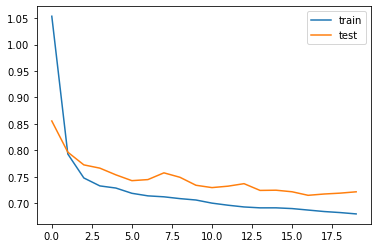

In [36]:
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'test')
plt.legend()
plt.show()

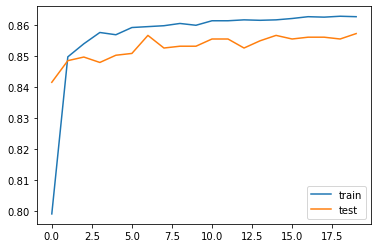

In [37]:
plt.plot(history.history['accuracy'], label = 'train')
plt.plot(history.history['val_accuracy'], label = 'test')
plt.legend()
plt.show()

In [38]:
y_predicted = classifier.predict(X_test)

y_predicted = np.argmax(y_predicted, axis = 1)

y_test = np.argmax(y_test, axis = 1)

test_sum = 0
for i in range(len(y_test)):
    test_sum += (y_test[i] * 15)

print(test_sum)

predicted_sum = 0
for i in range(len(y_predicted)):
    predicted_sum += (y_predicted[i] * 15)

print(predicted_sum)

print("Error Percentage in predicted values is : {} %".format(np.absolute((predicted_sum - test_sum)/test_sum)*100))
err.append(np.absolute((predicted_sum - test_sum)/test_sum)*100)

162150
154800
Error Percentage in predicted values is : 4.532839962997224 %


In [39]:
f1_score(y_test, y_predicted, average = 'weighted')

0.797357323832491

In [40]:
f1.append(f1_score(y_test, y_predicted, average = 'weighted'))

In [41]:
acc.append(max(history.history['accuracy']))

# February

In [42]:
working_df = house_data[house_data.Month == 2]

working_df = working_df[['T_ctrl', 'T_stp_heat', 'auxHeat1', 'T_out', 'RH_out']]
cols = ['T_ctrl', 'T_stp_heat', 'T_out', 'RH_out', 'auxHeat1']
working_df = working_df[cols]

reframed = series_to_supervised(working_df, 6, 1)

y_auxHeat = reframed['var5(t)']
y_auxHeat = to_categorical(y_auxHeat)
X = reframed.drop(labels = ["var5(t)"], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y_auxHeat, test_size = 0.2, shuffle = True)

X_train = X_train.values
X_test = X_test.values

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(4172, 34) (4172, 21) (1043, 34) (1043, 21)


In [43]:
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu', input_dim = 34))

# Adding the second hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the output layer
classifier.add(Dense(units = 21, kernel_initializer = 'uniform', activation = 'softmax'))

# Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy']) 

# Fitting the ANN to the Training set
history = classifier.fit(X_train, y_train, validation_data = (X_test, y_test), batch_size = 10, epochs = 20, shuffle = True)

Train on 4172 samples, validate on 1043 samples
Epoch 1/20
4172/4172 [==============================] - 2s 473us/sample - loss: 1.3000 - accuracy: 0.7821 - val_loss: 0.9268 - val_accuracy: 0.8284
Epoch 2/20
4172/4172 [==============================] - 2s 384us/sample - loss: 0.8979 - accuracy: 0.8272 - val_loss: 0.8700 - val_accuracy: 0.8341
Epoch 3/20
4172/4172 [==============================] - 2s 416us/sample - loss: 0.8574 - accuracy: 0.8298 - val_loss: 0.8463 - val_accuracy: 0.8303
Epoch 4/20
4172/4172 [==============================] - 2s 379us/sample - loss: 0.8367 - accuracy: 0.8325 - val_loss: 0.8303 - val_accuracy: 0.8370
Epoch 5/20
4172/4172 [==============================] - 2s 384us/sample - loss: 0.8243 - accuracy: 0.8351 - val_loss: 0.8181 - val_accuracy: 0.8389
Epoch 6/20
4172/4172 [==============================] - 2s 465us/sample - loss: 0.8174 - accuracy: 0.8360 - val_loss: 0.8136 - val_accuracy: 0.8399
Epoch 7/20
4172/4172 [==============================] - 2s 413us

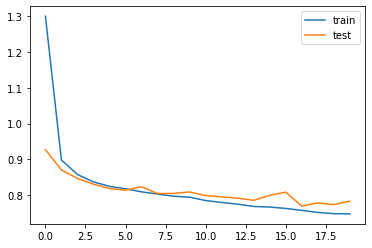

In [44]:
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'test')
plt.legend()
plt.show()

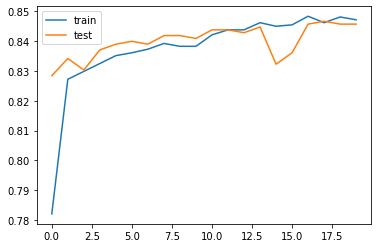

In [45]:
plt.plot(history.history['accuracy'], label = 'train')
plt.plot(history.history['val_accuracy'], label = 'test')
plt.legend()
plt.show()

In [46]:
y_predicted = classifier.predict(X_test)

y_predicted = np.argmax(y_predicted, axis = 1)

y_test = np.argmax(y_test, axis = 1)

test_sum = 0
for i in range(len(y_test)):
    test_sum += (y_test[i] * 15)

print(test_sum)

predicted_sum = 0
for i in range(len(y_predicted)):
    predicted_sum += (y_predicted[i] * 15)

print(predicted_sum)

print("Error Percentage in predicted values is : {} %".format(np.absolute((predicted_sum - test_sum)/test_sum)*100))
err.append(np.absolute((predicted_sum - test_sum)/test_sum)*100)

84930
83700
Error Percentage in predicted values is : 1.4482515012363122 %


In [47]:
f1_score(y_test, y_predicted, average = 'weighted')

0.7979449216904249

In [48]:
f1.append(f1_score(y_test, y_predicted, average = 'weighted'))

In [49]:
acc.append(max(history.history['accuracy']))

# March

In [50]:
working_df = house_data[house_data.Month == 3]

working_df = working_df[['T_ctrl', 'T_stp_heat', 'auxHeat1', 'T_out', 'RH_out']]
cols = ['T_ctrl', 'T_stp_heat', 'T_out', 'RH_out', 'auxHeat1']
working_df = working_df[cols]

reframed = series_to_supervised(working_df, 6, 1)

y_auxHeat = reframed['var5(t)']
y_auxHeat = to_categorical(y_auxHeat)
X = reframed.drop(labels = ["var5(t)"], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y_auxHeat, test_size = 0.2, shuffle = True)

X_train = X_train.values
X_test = X_test.values

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(6599, 34) (6599, 21) (1650, 34) (1650, 21)


In [51]:
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu', input_dim = 34))

# Adding the second hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the output layer
classifier.add(Dense(units = 21, kernel_initializer = 'uniform', activation = 'softmax'))

# Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy']) 

# Fitting the ANN to the Training set
history = classifier.fit(X_train, y_train, validation_data = (X_test, y_test), batch_size = 10, epochs = 20, shuffle = True)

Train on 6599 samples, validate on 1650 samples
Epoch 1/20
6599/6599 [==============================] - 3s 421us/sample - loss: 0.8513 - accuracy: 0.8685 - val_loss: 0.4455 - val_accuracy: 0.9152
Epoch 2/20
6599/6599 [==============================] - 3s 388us/sample - loss: 0.4552 - accuracy: 0.9209 - val_loss: 0.4124 - val_accuracy: 0.9230
Epoch 3/20
6599/6599 [==============================] - 3s 386us/sample - loss: 0.4387 - accuracy: 0.9247 - val_loss: 0.4034 - val_accuracy: 0.9267
Epoch 4/20
6599/6599 [==============================] - 2s 371us/sample - loss: 0.4277 - accuracy: 0.9250 - val_loss: 0.4413 - val_accuracy: 0.9206
Epoch 5/20
6599/6599 [==============================] - 2s 367us/sample - loss: 0.4217 - accuracy: 0.9260 - val_loss: 0.3944 - val_accuracy: 0.9248
Epoch 6/20
6599/6599 [==============================] - 2s 364us/sample - loss: 0.4144 - accuracy: 0.9279 - val_loss: 0.3996 - val_accuracy: 0.9261
Epoch 7/20
6599/6599 [==============================] - 2s 369us

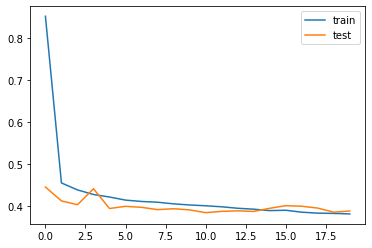

In [52]:
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'test')
plt.legend()
plt.show()

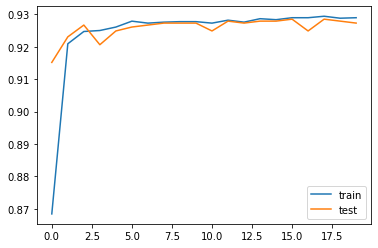

In [53]:
plt.plot(history.history['accuracy'], label = 'train')
plt.plot(history.history['val_accuracy'], label = 'test')
plt.legend()
plt.show()

In [54]:
y_predicted = classifier.predict(X_test)

y_predicted = np.argmax(y_predicted, axis = 1)

y_test = np.argmax(y_test, axis = 1)

test_sum = 0
for i in range(len(y_test)):
    test_sum += (y_test[i] * 15)

print(test_sum)

predicted_sum = 0
for i in range(len(y_predicted)):
    predicted_sum += (y_predicted[i] * 15)

print(predicted_sum)

print("Error Percentage in predicted values is : {} %".format(np.absolute((predicted_sum - test_sum)/test_sum)*100))
err.append(np.absolute((predicted_sum - test_sum)/test_sum)*100)

89850
90300
Error Percentage in predicted values is : 0.5008347245409015 %


In [55]:
f1_score(y_test, y_predicted, average = 'weighted')

0.8982908218879443

In [56]:
f1.append(f1_score(y_test, y_predicted, average = 'weighted'))

In [57]:
acc.append(max(history.history['accuracy']))

# April

In [58]:
working_df = house_data[house_data.Month == 4]

working_df = working_df[['T_ctrl', 'T_stp_heat', 'auxHeat1', 'T_out', 'RH_out']]
cols = ['T_ctrl', 'T_stp_heat', 'T_out', 'RH_out', 'auxHeat1']
working_df = working_df[cols]

reframed = series_to_supervised(working_df, 6, 1)

y_auxHeat = reframed['var5(t)']
y_auxHeat = to_categorical(y_auxHeat)
X = reframed.drop(labels = ["var5(t)"], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y_auxHeat, test_size = 0.2, shuffle = True)

X_train = X_train.values
X_test = X_test.values

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(6590, 34) (6590, 21) (1648, 34) (1648, 21)


In [59]:
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu', input_dim = 34))

# Adding the second hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the output layer
classifier.add(Dense(units = 21, kernel_initializer = 'uniform', activation = 'softmax'))

# Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy']) 

# Fitting the ANN to the Training set
history = classifier.fit(X_train, y_train, validation_data = (X_test, y_test), batch_size = 10, epochs = 20, shuffle = True)

Train on 6590 samples, validate on 1648 samples
Epoch 1/20
6590/6590 [==============================] - 3s 406us/sample - loss: 0.5287 - accuracy: 0.9379 - val_loss: 0.2928 - val_accuracy: 0.9587
Epoch 2/20
6590/6590 [==============================] - 2s 336us/sample - loss: 0.2222 - accuracy: 0.9630 - val_loss: 0.2684 - val_accuracy: 0.9587
Epoch 3/20
6590/6590 [==============================] - 2s 329us/sample - loss: 0.2041 - accuracy: 0.9657 - val_loss: 0.2486 - val_accuracy: 0.9593
Epoch 4/20
6590/6590 [==============================] - 2s 323us/sample - loss: 0.1941 - accuracy: 0.9660 - val_loss: 0.2398 - val_accuracy: 0.9606
Epoch 5/20
6590/6590 [==============================] - 2s 329us/sample - loss: 0.1863 - accuracy: 0.9663 - val_loss: 0.2357 - val_accuracy: 0.9618
Epoch 6/20
6590/6590 [==============================] - 2s 325us/sample - loss: 0.1803 - accuracy: 0.9680 - val_loss: 0.2291 - val_accuracy: 0.9618
Epoch 7/20
6590/6590 [==============================] - 2s 327us

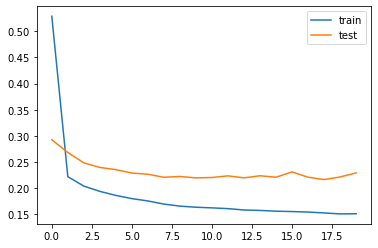

In [60]:
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'test')
plt.legend()
plt.show()

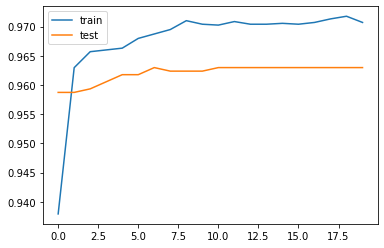

In [61]:
plt.plot(history.history['accuracy'], label = 'train')
plt.plot(history.history['val_accuracy'], label = 'test')
plt.legend()
plt.show()

In [62]:
y_predicted = classifier.predict(X_test)

y_predicted = np.argmax(y_predicted, axis = 1)

y_test = np.argmax(y_test, axis = 1)

test_sum = 0
for i in range(len(y_test)):
    test_sum += (y_test[i] * 15)

print(test_sum)

predicted_sum = 0
for i in range(len(y_predicted)):
    predicted_sum += (y_predicted[i] * 15)

print(predicted_sum)

print("Error Percentage in predicted values is : {} %".format(np.absolute((predicted_sum - test_sum)/test_sum)*100))
err.append(np.absolute((predicted_sum - test_sum)/test_sum)*100)

51825
48600
Error Percentage in predicted values is : 6.2228654124457305 %


In [63]:
f1_score(y_test, y_predicted, average = 'weighted')

0.9455690837269675

In [64]:
f1.append(f1_score(y_test, y_predicted, average = 'weighted'))

In [65]:
acc.append(max(history.history['accuracy']))

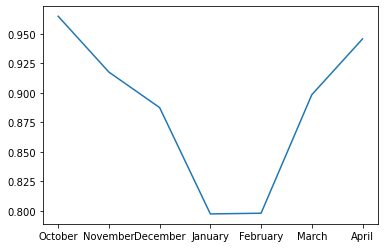

In [66]:
sns.lineplot(x = months, y = f1, sort = False)

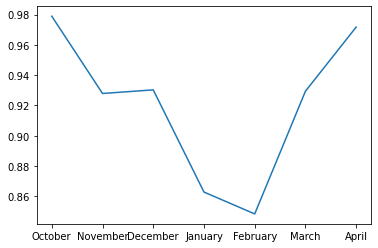

In [67]:
sns.lineplot(x = months, y = acc, sort = False)

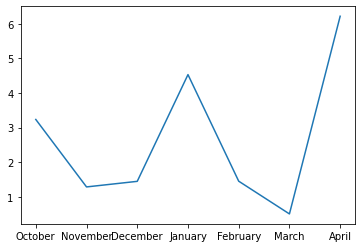

In [68]:
sns.lineplot(x = months, y = err, sort = False)